## Load libraries

In [1]:
from multitaper import MTSpec, MTCross
import multitaper.utils as utils
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

## Load Mesetas network data

In [2]:
data = utils.get_data('mesetas_src.dat')
dt   = 1/100.
npts,ntr = np.shape(data)

ptime = np.ones(ntr)
ptime[0:ntr+1:4] = 14.
ptime[1:ntr+1:4] = 24.
ptime[2:ntr+1:4] = 5.5
ptime[3:ntr+1:4] = 20.5
ptime[11*4-1:11*4+4] = ptime[11*4-1:11*4+4]-2. 
ptime[20] = 13.4

print('npts, # of traces, dt ',npts, ntr, dt)

npts, # of traces, dt  10001 76 0.01


In [3]:
# Select traces to work on
ista =  0
itr1 =  0+ista # Mainshock
itr2 = 16+ista
itr3 = 40+ista
itr4 = 68+ista  # 4 68

# Filter parameters for STF 
fmin = 0.2
fmax = 3.
fnyq = 0.5/dt
wn   = [fmin/fnyq,fmax/fnyq]
b, a = signal.butter(4, wn,'bandpass')

# Extract traces from data matrix
z1 = data[:,itr1]
z2 = data[:,itr2]
z3 = data[:,itr3]
z4 = data[:,itr4]

# MTSPEC parameters
nw    = 4.0
kspec = 6

# P-wave window length
wlen = 10.0 # window length, seconds
nlen = int(round(wlen/dt))

# Arrival times (-2 sec pre-P)
t_p1 = 12.2
t_p2 = 11.9
t_p3 = 12.1
t_p4 = 12.4

# Select to samples for each trace
ib1  = int(round((t_p1)/dt))
ib2  = int(round((t_p2)/dt))
ib3  = int(round((t_p3)/dt))
ib4  = int(round((t_p4)/dt)) # 12.6 12.4
ib5  = ib3 - nlen 
ib6  = ib4 - nlen 
ie1  = ib1 + nlen
ie2  = ib2 + nlen
ie3  = ib3 + nlen
ie4  = ib4 + nlen
ie5  = ib5 + nlen
ie6  = ib6 + nlen

# Select window around P-wave
y1 = z1[ib1:ie1]
y2 = z2[ib2:ie2]
y3 = z3[ib3:ie3]
y4 = z4[ib4:ie4]
y5 = z3[ib5:ie5]
y6 = z4[ib6:ie6]

# Get MTSPEC class
Py1   = MTSpec(y1,nw,kspec,dt)
Py2   = MTSpec(y2,nw,kspec,dt)
Py3   = MTSpec(y3,nw,kspec,dt)
Py4   = MTSpec(y4,nw,kspec,dt)
Py5   = MTSpec(y5,nw,kspec,dt)
Py6   = MTSpec(y6,nw,kspec,dt)

Pspec = [Py1, Py2, Py3, Py4, Py5, Py6]

# Get positive frequencies
freq ,spec1   = Py1.rspec()
freq ,spec2   = Py2.rspec()
freq ,spec3   = Py3.rspec()
freq ,spec4   = Py4.rspec()
freq ,spec5   = Py5.rspec()
freq ,spec6   = Py6.rspec()

# Get spectral ratio
sratio1 = np.sqrt(spec1/spec3)
sratio2 = np.sqrt(spec2/spec4)


P13  = MTCross(Py1,Py3,wl=0.001)
xcorr, dcohe, dconv  = P13.mt_corr()
dconv13 = signal.filtfilt(b, a, dconv[:,0])
P24  = MTCross(Py2,Py4,wl=0.001)
xcorr, dcohe, dconv2  = P24.mt_corr()
dconv24 = signal.filtfilt(b, a, dconv2[:,0])
nstf = (len(dconv24)-1)/2
tstf = np.arange(-nstf,nstf+1)*dt



## Display Figures

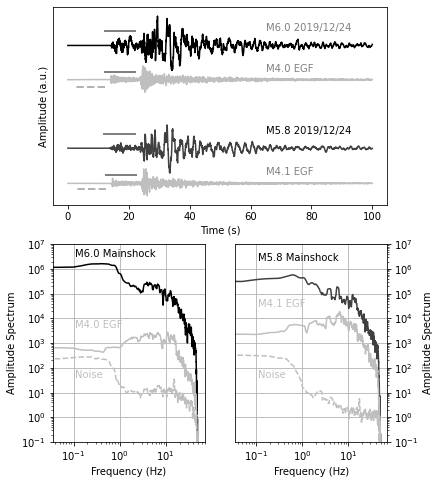

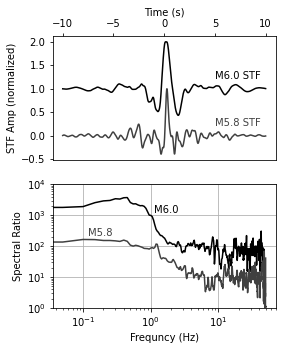

In [4]:
fig = plt.figure(1,figsize=(6,8))
t   = np.arange(len(z1))*dt
ax  = fig.add_subplot(2,2,1)
ax.plot(t,z1/np.max(z1)+4.7,'k')
ax.plot(t,z3/(2*np.max(z3))+3.5,color="0.75")
ax.plot(t,z2/np.max(z1)+1.2,color='0.25')
ax.plot(t,z4/(2*np.max(z4)),color="0.75")
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (a.u.)')
ax.set_yticks([])
ax.text(65,5.2,'M6.0 2019/12/24',color='0.5')
ax.text(65,3.8,'M4.0 EGF',color='0.5')
ax.text(65,1.7,'M5.8 2019/12/24')
ax.text(65,0.3,'M4.1 EGF',color='0.5')
ax.plot([t_p1,t_p1+wlen],[5.2,5.2],color='0.5',linewidth=2.0)
ax.plot([t_p3,t_p3+wlen],[3.8,3.8],color='0.5',linewidth=2.0)
ax.plot([t_p2,t_p2+wlen],[1.7,1.7],color='0.5',linewidth=2.0)
ax.plot([t_p4,t_p4+wlen],[0.3,0.3],color='0.5',linewidth=2.0)
ax.plot([t_p3,t_p3-wlen],[3.3,3.3],'--',color='0.7',linewidth=2.0)
ax.plot([t_p4,t_p4-wlen],[-0.2,-0.2],'--',color='0.7',linewidth=2.0)
box    = ax.get_position()
box.x1 = 0.89999
ax.set_position(box)

ax  = fig.add_subplot(2,2,3)
ax.loglog(freq,np.sqrt(spec1*wlen),'k')
ax.loglog(freq,np.sqrt(spec3*wlen),color='0.75')
ax.loglog(freq,np.sqrt(spec5*wlen),'--',color='0.75')
ax.grid()
ax.set_ylim(1e-1,1e7)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude Spectrum')
ax2  = fig.add_subplot(2,2,4)
ax2.loglog(freq,np.sqrt(spec2*wlen),color='0.25')
ax2.loglog(freq,np.sqrt(spec4*wlen),color='0.75')
ax2.loglog(freq,np.sqrt(spec6*wlen),'--',color='0.75')
ax2.grid()
ax2.set_ylim(1e-1,1e7)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude Spectrum')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax.text(0.11,3.1e6,'M6.0 Mainshock')
ax.text(0.11,4e3,'M4.0 EGF',color='0.75')
ax.text(0.11,4e1,'Noise',color='0.75')
ax2.text(0.11,2.1e6,'M5.8 Mainshock')
ax2.text(0.11,3e4,'M4.1 EGF',color='0.75')
ax2.text(0.11,4e1,'Noise',color='0.75')
plt.savefig('figures/src_waveforms.jpg')

fig = plt.figure(figsize=(4,5))
ax  = fig.add_subplot(2,1,1)
ax.plot(tstf,dconv13/np.max(np.abs(dconv13))+1,'k')
ax.plot(tstf,dconv24/np.max(np.abs(dconv24)),color='0.25')
ax.set_ylabel('STF Amp (normalized)')
ax.text(5,1.2,'M6.0 STF')
ax.text(5,0.2,'M5.8 STF',color='0.25')
ax.set_xlabel('Time (s)')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

ax2  = fig.add_subplot(2,1,2)
ax2.loglog(freq,sratio1,'k')
ax2.loglog(freq,sratio2,color='0.25')
ax2.set_ylim(1e0,1e4)
ax2.set_xlabel('Frequncy (Hz)')
ax2.set_ylabel('Spectral Ratio')
ax2.text(1.1,1.2e3,'M6.0')
ax2.text(0.12,2.1e2,'M5.8',color='0.25')
ax2.grid()
plt.savefig('figures/src_stf.jpg')